#**Scale Data with Outliers**

Many machine learning algorithms perform better when numerical input variables are scaled to
a standard range. This includes algorithms that use a weighted sum of the input, like linear
regression, and algorithms that use distance measures, like k-nearest neighbors. Standardizing
is a popular scaling technique that subtracts the mean from values and divides by the standard
deviation, transforming the probability distribution for an input variable to a standard Gaussian
(zero mean and unit variance). Standardization can become skewed or biased if the input
variable contains outlier values.
To overcome this, the median and interquartile range can be used when standardizing
numerical input variables, generally referred to as robust scaling.

In this tutorial, you will learn:

* Many machine learning algorithms prefer or perform better when numerical input variables
are scaled.
* Robust scaling techniques that use percentiles to scale numerical input
variables that contain outliers.
* How to use the RobustScaler to scale numerical input variables using the median and
interquartile range.

Adapted from Jason Brownlee. 2020. [Data Preparation for Machine Learning](https://machinelearningmastery.com/data-preparation-for-machine-learning/).



##Robust Scaling Data
If there are input
variables that have very large values relative to the other input variables, these large values
can dominate or skew some machine learning algorithms. The result is that the algorithms pay
most of their attention to the large values and ignore the variables with smaller values.

Sometimes an input variable may have outlier values. Outliers can skew a probability distribution and make data scaling using standardization
difficult as the calculated mean and standard deviation will be skewed by the presence of
the outliers. 

Robust standardization or robust data
scaling that calculates the median (50th percentile) and the 25th and
75th percentiles. The values of each variable then have their median subtracted and are divided
by the interquartile range (IQR) which is the difference between the 75th and 25th percentiles


##Diabetes Dataset
The dataset classifies patient data as
either an onset of diabetes within five years or not. 
```
Number of Instances: 768
Number of Attributes: 8 plus class 
For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)
Missing Attribute Values: Yes
Class Distribution: (class value 1 is interpreted as "tested positive for
   diabetes")
   Class Value  Number of instances
   0            500
   1            268
```

You can learn more about the dataset here:

* Diabetes Dataset File ([pima-indians-diabetes.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv))
* Diabetes Dataset Details ([pima-indians-diabetes.names](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names))

###Download Diabetes data files

In [1]:
!pip install wget
!python -m wget "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv" -o pima-indians-diabetes.csv
!python -m wget "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names" -o pima-indians-diabetes.names

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a4468db075b9056774004834554afcb7056fb57156716590fefb7095a736787f
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget

Saved under pima-indians-diabetes.csv

Saved under pima-indians-diabetes.names


In [2]:
# load and summarize the diabetes dataset
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pima-indians-diabetes.csv', header=None)
print(dataset.head())
# summarize the shape of the dataset
print(dataset.shape)
# summarize each variable
print(dataset.describe())

   0    1   2   3    4     5      6   7  8
0  6  148  72  35    0  33.6  0.627  50  1
1  1   85  66  29    0  26.6  0.351  31  0
2  8  183  64   0    0  23.3  0.672  32  1
3  1   89  66  23   94  28.1  0.167  21  0
4  0  137  40  35  168  43.1  2.288  33  1
(768, 9)
                0           1           2           3           4           5  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120.894531   69.105469   20.536458   79.799479   31.992578   
std      3.369578   31.972618   19.355807   15.952218  115.244002    7.884160   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   30.500000   32.000000   
75%      6.000000  140.250000   80.000000   32.000000  127.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

   

This confirms the 8
input variables, one output variable, and 768 rows of data. A statistical summary of the input
variables is provided show that each variable has a very different scale. This makes it a good
dataset for exploring data scaling methods.

We can create a histogram for each input variable. The plots confirm the differing scale
for each input variable and show that the variables have differing scales. Importantly, we can see
some of the distributions show the presence of outliers. The dataset provides a good candidate for using a robust scaler transform to standardize the data in the presence of di ering input
variable scales and outliers.

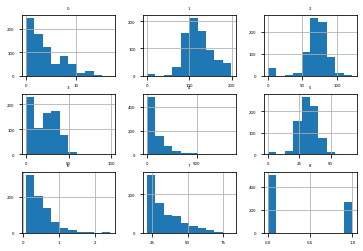

In [3]:
# histograms of the variables
fig = dataset.hist(xlabelsize=4, ylabelsize=4)
[x.title.set_size(4) for x in fig.ravel()]
# show the plot
pyplot.show()

Next, let's fit and evaluate a machine learning model on the raw dataset. We will use
a k-nearest neighbor algorithm with default hyperparameters and evaluate it using repeated
stratified k-fold cross-validation.

In [4]:
# evaluate knn on the raw diabetes dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
# load dataset
dataset = read_csv('pima-indians-diabetes.csv', header=None)
data = dataset.values
# separate into input and output columns
X, y = data[:, :-1], data[:, -1]
# ensure inputs are floats and output is an integer label
X = X.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))
# define and configure the model
model = KNeighborsClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report model performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.717 (0.040)


In this case we can see that the model achieved a mean classi cationfiaccuracy of about
71.7 percent.

Next, let's explore a robust scaling transform of the dataset.

##IQR Robust Scaler Transform
We can apply the robust scaler to the diabetes dataset directly. We will use the default
configuration and scale values to the IQR. First, a **RobustScaler** instance is defined with
default hyperparameters. Once defined, we can call the **fit.transform()** function and pass it
to our dataset to create a robust scale transformed version of our dataset.

In [5]:
# visualize a robust scaler transform of the diabetes dataset
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import RobustScaler
from matplotlib import pyplot
# load dataset
dataset = read_csv('pima-indians-diabetes.csv', header=None)
# retrieve just the numeric input values
data = dataset.values[:, :-1]
# perform a robust scaler transform of the dataset
trans = RobustScaler()
data = trans.fit_transform(data)
# convert the array back to a dataframe
dataset = DataFrame(data)
# summarize
print(dataset.describe())

                0           1           2           3           4           5  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     0.169010    0.094413   -0.160807   -0.076986    0.387422   -0.000798   
std      0.673916    0.775094    1.075323    0.498507    0.905650    0.847759   
min     -0.600000   -2.836364   -4.000000   -0.718750   -0.239686   -3.440860   
25%     -0.400000   -0.436364   -0.555556   -0.718750   -0.239686   -0.505376   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.600000    0.563636    0.444444    0.281250    0.760314    0.494624   
max      2.800000    1.987879    2.777778    2.375000    6.408644    3.774194   

                6           7  
count  768.000000  768.000000  
mean     0.259807    0.249464  
std      0.866219    0.691778  
min     -0.769935   -0.470588  
25%     -0.336601   -0.294118  
50%      0.000000    0.000000  
75%      0.663399    0.705882  
max      5.352

We can see that the
distributions have been adjusted. The median values are now zero and the standard deviation
values are now close to 1.0.

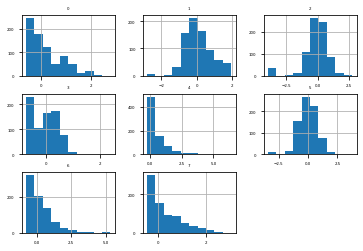

In [6]:
# histograms of the variables
fig = dataset.hist(xlabelsize=4, ylabelsize=4)
[x.title.set_size(4) for x in fig.ravel()]
# show the plot
pyplot.show()

Histogram plots of the variables are created, although the distributions don't look much
different from their original distributions seen in the previous section. We can see that the
center of mass for each distribution is now close to zero.

Next, let's evaluate the same KNN model as the previous section, but in this case on a
robust scaler transform of the dataset.

In [7]:
# evaluate knn on the diabetes dataset with robust scaler transform
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
# load dataset
dataset = read_csv('pima-indians-diabetes.csv', header=None)
data = dataset.values
# separate into input and output columns
X, y = data[:, :-1], data[:, -1]
# ensure inputs are floats and output is an integer label
X = X.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))
# define the pipeline
trans = RobustScaler()
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[('t', trans), ('m', model)])
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.734 (0.044)


We can see that the robust scaler transform results in a lift in
performance from 71.7 percent accuracy without the transform to about 73.4 percent with the
transform.

##Explore Robust Scaler Range
The range used to scale each variable is chosen by default as the IQR is bounded by the 25th
and 75th percentiles. This is specified by the quantile range argument as a tuple. Other
values can be specified and might improve the performance of the model, such as a wider range,
allowing fewer values to be considered outliers, or a more narrow range, allowing more values
to be considered outliers. The example below explores the effect of different definitions of the
range from 1st to the 99th percentiles to 30th to 70th percentiles.

In [8]:
# explore the scaling range of the robust scaler transform
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# get the dataset
def get_dataset():
  # load dataset
  dataset = read_csv('pima-indians-diabetes.csv', header=None)
  data = dataset.values
  # separate into input and output columns
  X, y = data[:, :-1], data[:, -1]
  # ensure inputs are floats and output is an integer label
  X = X.astype('float32')
  y = LabelEncoder().fit_transform(y.astype('str'))
  return X, y

# get a list of models to evaluate
def get_models():
  models = dict()
  for value in [1, 5, 10, 15, 20, 25, 30]:
  # define the pipeline
    trans = RobustScaler(quantile_range=(value, 100-value))
    model = KNeighborsClassifier()
    models[str(value)] = Pipeline(steps=[('t', trans), ('m', model)])
  return models
  
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, y)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>1 0.734 (0.054)
>5 0.736 (0.051)
>10 0.739 (0.047)
>15 0.740 (0.045)
>20 0.734 (0.050)
>25 0.734 (0.044)
>30 0.735 (0.042)


We can see that ranges such as 10-90 and 15-85 perform better than the default
of 25-75.

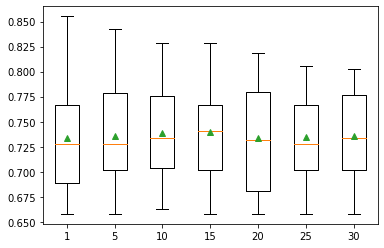

In [9]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Box and whisker plots are created to summarize the classification accuracy scores for each
IQR range. We can see a subtle difference in the distribution and mean accuracy with the larger
ranges of 15-85 vs 25-75. percentiles.